In [684]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import polars as pl
import datetime

data = yf.download(tickers='BTC-USD', period='max', interval='1d')

[*********************100%***********************]  1 of 1 completed


SLOPE, INTERCEPTS and difference STEPS

In [703]:
# 2 argument l avna
def direction_and_steps(datapoints):
    if datapoints.index[0] > datapoints.index[1]:
        startIndex = datapoints.index[0]
        endIndex = datapoints.index[1]
    else:
        startIndex = datapoints.index[1]
        endIndex = datapoints.index[0]
    a = datapoints.head(1)
    b = datapoints.tail(1)
    a_value = a[0]
    b_value = b[0]
    ascending = False

# ========================
    if b.index < a.index:
        oldIndex = b.index
        newIndex = a.index
        if b_value > a_value:
            max = b_value
            min = a_value
            ascending = False
            print("descending")
        else:
            max = a_value
            min = b_value
            ascending = True
            print('ascending')
    elif b.index > a.index:
        oldIndex = a.index
        newIndex = b.index
        if b_value > a_value:
            max = b_value
            min = a_value
            ascending = True
            print('ascending')
        else:
            max = a_value
            min = b_value
            ascending = False
            print('descending')
    top_diff = max - min
    print('difference = ', top_diff)
    filtered = df[(df.index <= startIndex) & (df.index >= endIndex)]
    numrange = len(filtered)
    print('range =', numrange)
    diff_step = top_diff/numrange
    return diff_step, ascending

resistance_points = resistances.sort_values(ascending=False).tail(2)

diff_step, lineAscending = direction_and_steps(resistance_points)
print('diff = ', diff_step)
lineAscending

ascending
difference =  4.069000244140625
range = 33
diff =  0.12330303770123106


True

RETURN min & max from 2 POINTS

In [700]:
def min_max(datapoints):
    a = datapoints.head(1)
    b = datapoints.tail(1)
    a_value = a[0]
    b_value = b[0]
    if b_value > a_value:
        max = b_value
        min = a_value
        print("max= ", max, "min= ", min)
    else:
        max = a_value
        min = b_value
        print("max= ", max, "min= ", min)
    return min, max

In [701]:
min_max(resistance_points)

max=  241.97799682617188 min=  237.90899658203125


(237.90899658203125, 241.97799682617188)

EXTREMUM hoorondiin data range easify

In [702]:
def start_end_ragne(datapoints):
    if datapoints.index[1] > datapoints.index[0]:
        startIndex = datapoints.index[0]
        endIndex = datapoints.index[1]
    else:
        startIndex = datapoints.index[1]
        endIndex = datapoints.index[0]
    return startIndex, endIndex

start, end = start_end_ragne(resistance_points)
print("started= ", start)
print('ended =', end)

started=  2015-04-22 00:00:00
ended = 2015-05-24 00:00:00


LEVELS

In [704]:
resistances

Date
2015-04-22    237.908997
2015-05-03    243.240005
2015-05-09    247.804001
2015-05-24    241.977997
2015-06-17    256.852997
2015-06-30    267.867004
Name: High, dtype: float64

RESISTANCE until NOW

In [712]:
def resistance(df):
    print("Calculating resistance")
    resistances = df[df.High == df.High.rolling(10, center=True).max()].High
    resistance_points = resistances.sort_values(ascending=True).tail(2)

    # resistance coefficients
    diff_step, lineAscending = direction_and_steps(resistance_points)
    start, end = start_end_ragne(resistance_points)
    # today = df[(df.index > resistance_points.index[0])]
    today = df[(df.index > start)]

    x_values = []
    y_values = []

    min, max = min_max(resistance_points)
    y = resistance_points[0]
    # today['resistance'] = np.nan

    if lineAscending == True:
        y = min
        for i in today.index:
            y = y + diff_step
            y_values.append(y)
            x_values.append(i)
            # today.loc[today.index==i, 'resistance'] = y
            df.loc[df.index==i, 'resistance'] = y
    elif lineAscending == False:
        y = max
        for i in today.index:
            y = y - diff_step
            y_values.append(y)
            x_values.append(i)
            # today.loc[today.index==i, 'resistance'] = y
            df.loc[df.index==i, 'resistance'] = y

    print("Resistance ascending", lineAscending)
    print("Diff points", diff_step)
    # y_values
# ==== run test ====
resistance(df)

Calculating resistance
ascending
difference =  11.014007568359375
range = 14
max=  267.86700439453125 min=  256.8529968261719
Resistance ascending True
Diff points 0.7867148263113839


In [711]:
resistance_points

Date
2015-05-24    241.977997
2015-04-22    237.908997
Name: High, dtype: float64

In [ ]:
resistances

Date
2016-05-29    553.960022
2016-06-18    777.989990
2016-07-03    704.968018
2016-07-17    682.364990
2016-08-10    599.984009
Name: High, dtype: float64

SUPPORT

In [ ]:
def support(df):
    print("Calculating support")
    supports = df[df.Low == df.Low.rolling(10, center=True).min()].Low
    support_points = supports.sort_values(ascending=True).head(2)
    
    # start_point
    start, end = start_end_ragne(support_points)
    support_today = df[(df.index > start)]
    # support coefficients
    diff_step, lineAscending = direction_and_steps(support_points)

    numrange = len(support_today)
    x_values = []
    y_values = []

    min, max = min_max(support_points)
    y = support_points[0]
    # support_today['support'] = np.nan

    if lineAscending == True:
        y = min
        print("Ascending")
        for i in support_today.index:
            y = y + diff_step
            y_values.append(y)
            x_values.append(i)
            # support_today.loc[support_today.index==i, 'support'] = y
            df.loc[df.index==i, 'support'] = y
    elif lineAscending == False:
        y = max
        for i in support_today.index:
            y = y - diff_step
            y_values.append(y)
            x_values.append(i)
            # support_today.loc[support_today.index==i, 'support'] = y
            df.loc[df.index==i, 'support'] = y
        print("Descending")

    print("Resistance ascending", lineAscending)
    print("Diff points", diff_step)

# run test
support(df)

Calculating support
ascending
difference =  25.491012573242188
range = 61
max=  240.36500549316406 min=  214.87399291992188
Ascending
Resistance ascending True
Diff points 0.41788545202036376


PLOTTING

In [ ]:
clean_levels

Date
2016-06-23    558.138977
2016-07-07    611.833984
2016-07-22    646.721985
2016-05-29    553.960022
2016-06-07    590.258972
2016-06-18    777.989990
2016-07-17    682.364990
dtype: float64

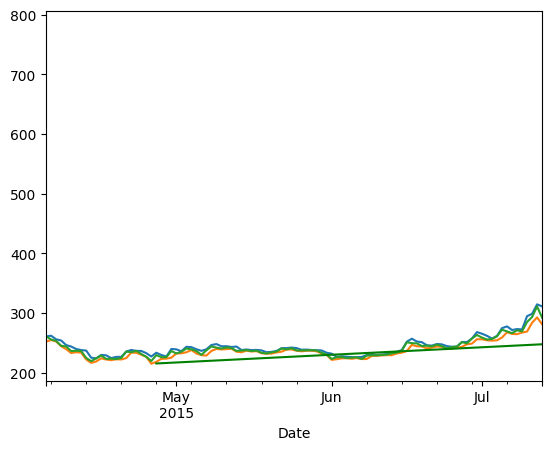

In [ ]:
now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
now
save_name = "cryptochart_"+now
save_name
clean_levels = levels[abs(levels.diff() > 0)]
df.High.plot()
df.Low.plot()
df.Close.plot()
plt.hlines(clean_levels, xmin=clean_levels.index, xmax=clean_levels.index[-1], colors='red')
plt.scatter(resistances.index, resistances, color='b')
# plt.scatter(support_points.index, support_points, color="g")
plt.plot(df.index, df['resistance'], color="r")
plt.plot(df.index, df['support'], color="g")
# plt.plot(today.index, y_values, color="y")

PLOTTING and SAVE

In [ ]:
# ====== PLOTTING and SAVING =========
# MATPLOTLIB
# clean_levels = levels[abs(levels.diff() > 0)]
def plot_df(df):
    df.High.plot()
    df.Low.plot()
    df.Close.plot()
    # plt.hlines(clean_levels, xmin=clean_levels.index, xmax=clean_levels.index[-1], colors='red')
    plt.scatter(resistances.index, resistances, color='b')
    # plt.scatter(support_points.index, support_points, color="g")
    plt.plot(df.index, df['resistance'], color="r")
    plt.plot(df.index, df['support'], color="g")
    # plt.plot(today.index, y_values, color="y")
    startDate = df.index[0].strftime("%Y-%m-%d")
    endDate = df.index[-1].strftime("%Y-%m-%d")
    save_name = startDate + '_to_' + endDate
    save_name
    plt.savefig('testImages/'+save_name+'_signals.jpg')

Test with Iteration

dataStart=  0  i=  100
Calculating resistance
descending
difference =  62.391998291015625
range = 13
max=  457.0929870605469 min=  394.70098876953125
Resistance ascending False
Diff points 4.799384483924279
Calculating support
ascending
difference =  14.936004638671875
range = 75
max=  304.23199462890625 min=  289.2959899902344
Ascending
Resistance ascending True
Diff points 0.199146728515625


/tmp/ipykernel_3191/2920431357.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/2920431357.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



dataStart=  100  i=  200
Calculating resistance
descending
difference =  9.339996337890625
range = 44
max=  309.3840026855469 min=  300.04400634765625
Resistance ascending False
Diff points 0.21227264404296875
Calculating support
ascending
difference =  65.0050048828125
range = 71
max=  236.51499938964844 min=  171.50999450683594
Ascending
Resistance ascending True
Diff points 0.9155634490536971


/tmp/ipykernel_3191/2920431357.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/2920431357.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



dataStart=  200  i=  300
Calculating resistance


/tmp/ipykernel_3191/2920431357.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/2920431357.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



UnboundLocalError: local variable 'max' referenced before assignment

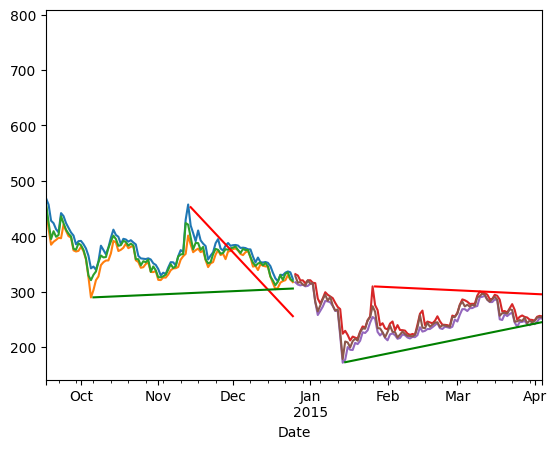

In [ ]:
dataStart = 0
for i in range(100, len(data),100):
    print('dataStart= ', dataStart, ' i= ', i)
    # ==== setting range of df ====
    df = data[dataStart:i]
    df['resistance'] = np.nan
    df['support'] = np.nan
    # plt.plot(df.index, df.Close)
    # plt.show()
    # ===== Calculate Channel ====
    resistance(df)
    support(df)
    plot_df(df)
    dataStart = i


TEST by ONE

/tmp/ipykernel_3191/1058920205.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/1058920205.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Calculating resistance
descending
difference =  73.02197265625
range = 16
max=  777.989990234375 min=  704.968017578125
Resistance ascending False
Diff points 4.563873291015625
Calculating support
ascending
difference =  93.94497680664062
range = 75
max=  531.333984375 min=  437.3890075683594
Ascending
Resistance ascending True
Diff points 1.2525996907552084


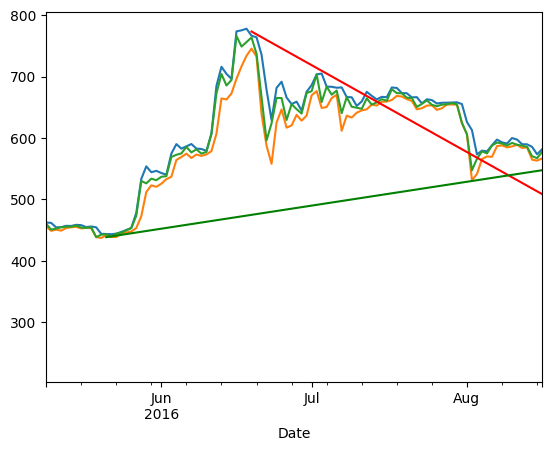

In [ ]:
df = data[600:700]
df['resistance'] = np.nan
df['support'] = np.nan
# plt.plot(df.index, df.Close)
# plt.show()
# ===== Calculate Channel ====
resistance(df)
support(df)
plot_df(df)

УРТ ХУГАЦААГААР ХАРАХ ХЭСЭГ

In [ ]:
# with indicator
# df = data
# df['resistance'] = np.nan
# df['support'] = np.nan
# # plt.plot(df.index, df.Close)
# # plt.show()
# # ===== Calculate Channel ====
# resistance(df)
# support(df)
# plot_df(df)
# ===== PLOTLY =====
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                    open=df['Open'],
                                    high=df['High'],
                                    low=df['Low'],
                                    close=df['Close'],
                                    increasing_line_color='green',
                                    decreasing_line_color='red'),
                                    go.Scatter(x=df.index, y=df['support'], line=dict(color="green", width=3), name="SUPPORT"),
                                    go.Scatter(x=df.index, y=df['resistance'], line=dict(color='red', width=3), name="RESISTANCE"),
                                    go.Scatter(x=df.index, y=supports, mode="markers", marker=dict(size=5, color="Orange"), name="Buy")])

fig.update(layout_xaxis_rangeslider_visible=True)
fig.update_layout(paper_bgcolor="black", plot_bgcolor="black", margin_l=0, margin_b=0, margin_r=0, margin_t=0)
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.show()

POLARS
update row